In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import pyspark as sp
from pyspark.sql.functions import col, year, to_timestamp, sum as _sum, desc, date_format, countDistinct, collect_set, round, first
from pyspark.sql import functions as F
from pyspark.sql import Row
import matplotlib.pyplot as plt
import os
from calendar import month_name

In [2]:
spark = sp.sql.SparkSession.builder.appName("Merging Weather").master("local[4]").config("spark.driver.memory", "6g").getOrCreate()

In [3]:
df = spark.read.parquet("D:/data/mta_top20_joined_1")

In [4]:
df.printSchema()

root
 |-- station_complex: string (nullable = true)
 |-- transit_timestamp: string (nullable = true)
 |-- station_complex_id: string (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- fare_class_category: string (nullable = true)
 |-- ridership: integer (nullable = true)
 |-- transfers: integer (nullable = true)
 |-- transit_mode: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- temperature_C: string (nullable = true)
 |-- precipitation_mm: string (nullable = true)
 |-- humidity_%: string (nullable = true)



In [9]:
df.select("station_complex_id").distinct().show()

+------------------+
|station_complex_id|
+------------------+
|               451|
|                51|
|               447|
|               434|
|               610|
|               617|
|               120|
|               164|
|               604|
|               345|
|               450|
|               616|
|               366|
|               382|
|               318|
|               371|
|               607|
|               630|
|               278|
|               611|
+------------------+



In [11]:
df.select("station_complex").distinct().show(truncate = False)

+--------------------------------------------------+
|station_complex                                   |
+--------------------------------------------------+
|Jamaica Center-Parsons/Archer (E,J,Z)             |
|Fordham Rd (4)                                    |
|34 St-Penn Station (1,2,3)                        |
|Myrtle-Wyckoff Avs (L,M)                          |
|Flushing-Main St (7)                              |
|Junction Blvd (7)                                 |
|161 St-Yankee Stadium (B,D,4)                     |
|74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,M,R)|
|Bedford Av (L)                                    |
|Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)  |
|Kings Hwy (B,Q)                                   |
|3 Av-149 St (2,5)                                 |
|34 St-Herald Sq (B,D,F,M,N,Q,R,W)                 |
|Grand Central-42 St (S,4,5,6,7)                   |
|Hunts Point Av (6)                                |
|103 St-Corona Plaza (7)                      

In [8]:
df.select("payment_method").distinct().show()

+--------------+
|payment_method|
+--------------+
|     metrocard|
|          omny|
+--------------+



In [6]:
df.select("fare_class_category").distinct().show()

+--------------------+
| fare_class_category|
+--------------------+
|Metrocard - Fair ...|
|    OMNY - Fair Fare|
|OMNY - Seniors & ...|
|    OMNY - Full Fare|
|Metrocard - Unlim...|
|Metrocard - Unlim...|
|Metrocard - Full ...|
|   Metrocard - Other|
|Metrocard - Senio...|
|Metrocard - Students|
|        OMNY - Other|
|     OMNY - Students|
+--------------------+



In [7]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [12]:
def plot_station_ridership(df, fare_category, payment_method, year, month=None, station_identifier=None, output_dir="station_charts", max_rows_per_station=10000):
    """
    Generate bar charts for ridership at a specific station complex (or all stations if not specified)
    for a specific fare category, payment method, year, and optional month. Each chart will have a custom y-axis scale.

    Parameters:
    - df: PySpark DataFrame with the specified schema
    - fare_category: String, e.g., 'OMNY - Full Fare'
    - payment_method: String, e.g., 'OMNY'
    - year: Integer, e.g., 2023
    - month: Integer, 1-12 to filter a specific month (optional, defaults to None for all months)
    - station_identifier: String, either station_complex or station_complex_id to filter a specific station (optional)
    - output_dir: Directory to save the charts
    - max_rows_per_station: Maximum rows to process per station to prevent memory issues (default: 10000).
      Limits the number of data points collected for plotting to avoid excessive memory usage.
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Debug: Inspect unique values in relevant columns
    logger.info("Inspecting unique values in the dataset...")
    fare_categories = df.select("fare_class_category").distinct().collect()
    payment_methods = df.select("payment_method").distinct().collect()
    station_complexes = df.select("station_complex").distinct().collect()
    station_ids = df.select("station_complex_id").distinct().collect()

    logger.info(f"Available fare_class_category values: {[row['fare_class_category'] for row in fare_categories]}")
    logger.info(f"Available payment_method values: {[row['payment_method'] for row in payment_methods]}")
    logger.info(f"Available station_complex values: {[row['station_complex'] for row in station_complexes]}")
    logger.info(f"Available station_complex_id values: {[row['station_complex_id'] for row in station_ids]}")

    # Debug: Inspect transit_timestamp values
    logger.info("Inspecting transit_timestamp values...")
    sample_timestamps = df.select("transit_timestamp").limit(5).collect()
    logger.info(f"Sample transit_timestamp values: {[row['transit_timestamp'] for row in sample_timestamps]}")

    # Check for null timestamps
    null_timestamp_count = df.filter(df.transit_timestamp.isNull()).count()
    total_count = df.count()
    logger.info(f"Null transit_timestamp count: {null_timestamp_count} out of {total_count} records")

    # Parse transit_timestamp with the correct format
    df_with_timestamp = df.withColumn("parsed_timestamp", F.to_timestamp("transit_timestamp", "MM/dd/yyyy hh:mm:ss a"))

    # Debug: Verify parsing
    sample_parsed = df_with_timestamp.select("transit_timestamp", "parsed_timestamp").limit(5).collect()
    logger.info("Sample parsed timestamps:")
    for row in sample_parsed:
        logger.info(f"Raw: {row['transit_timestamp']}, Parsed: {row['parsed_timestamp']}")

    # Extract years
    years = df_with_timestamp.select(F.year("parsed_timestamp").alias("year")).distinct().collect()
    valid_years = [row["year"] for row in years if row["year"] is not None]
    logger.info(f"Available years after parsing: {valid_years}")

    if not valid_years:
        logger.error("No valid years found. Please verify the transit_timestamp format matches 'MM/dd/yyyy hh:mm:ss a'.")
        return

    # Filter by year, fare category, and payment method
    filtered_df = df_with_timestamp.filter(
        (F.year("parsed_timestamp") == year) &
        (df.fare_class_category == fare_category) &
        (df.payment_method == payment_method)
    )

    # Apply month filter if specified
    if month is not None:
        if not 1 <= month <= 12:
            logger.error("Month must be between 1 and 12. Exiting.")
            return
        filtered_df = filtered_df.filter(F.month("parsed_timestamp") == month)
        logger.info(f"Filtering for month: {month_name[month]}")

    # Cache and repartition filtered DataFrame to optimize memory usage
    filtered_df = filtered_df.repartition(10).cache()

    # Check the number of records
    record_count = filtered_df.count()
    logger.info(f"Filtered dataset contains {record_count} records")
    if record_count == 0:
        logger.warning("No data available after filtering. Exiting. Please check the filter parameters against available values logged above.")
        filtered_df.unpersist()
        return

    # Group by station_complex, date, and month (if applicable), summing ridership
    agg_df = filtered_df.groupBy(
        "station_complex",
        F.date_format("parsed_timestamp", "yyyy-MM-dd").alias("date")
    ).agg(
        F.sum("ridership").alias("total_ridership")
    ).orderBy("station_complex", "date")

    # Check PySpark version
    spark_version = sp.__version__
    logger.info(f"Using PySpark version: {spark_version}")

    # Determine the stations to process
    if station_identifier:
        # Check if station_identifier matches station_complex or station_complex_id
        stations = [row["station_complex"] for row in filtered_df.filter(
            (filtered_df.station_complex == station_identifier) |
            (filtered_df.station_complex_id == station_identifier)
        ).select("station_complex").distinct().collect()]
        if not stations:
            logger.error(f"No station found matching identifier: {station_identifier}. Exiting.")
            filtered_df.unpersist()
            return
        logger.info(f"Processing single station: {stations[0]} (identifier: {station_identifier})")
    else:
        # Process all stations if no identifier is provided
        stations = [row["station_complex"] for row in agg_df.select("station_complex").distinct().collect()]
        logger.info(f"Processing all stations. Found {len(stations)} unique stations.")

    # Generate a bar chart for the specified station(s)
    for station in stations:
        logger.info(f"Generating chart for station: {station}")

        # Filter data for the current station
        station_df = agg_df.filter(agg_df.station_complex == station)

        try:
            # Collect data as a list of rows, limiting to max_rows_per_station
            station_rows = station_df.limit(max_rows_per_station).collect()

            # Convert to Pandas DataFrame manually
            pandas_df = pd.DataFrame(
                [(row["date"], row["total_ridership"]) for row in station_rows],
                columns=["date", "total_ridership"]
            )

            # Skip if no data
            if pandas_df.empty:
                logger.warning(f"No data for station: {station}")
                continue

            plt.figure(figsize=(12, 6))
            plt.bar(pandas_df["date"], pandas_df["total_ridership"], color='blue', label="Ridership")

            # Set title and labels with proper encoding, including the month if specified
            title_month = f"{month_name[month]} " if month else ""
            plt.title(f"Daily Ridership at {station}\n{fare_category}, {payment_method}, {title_month}{year}")
            plt.xlabel("Date")
            plt.ylabel("Total Ridership")

            # Add grid for better readability
            plt.grid(True, axis='y', linestyle='--', alpha=0.7)

            # Adjust x-axis ticks based on the number of days
            num_days = len(pandas_df)
            if num_days > 0:
                step = max(1, num_days // 5)  # Show roughly 5 ticks
                plt.xticks(pandas_df["date"][::step], rotation=45, ha='right')

            # Custom y-axis scale based on the max ridership for this station
            max_ridership = pandas_df["total_ridership"].max()
            if max_ridership <= 0:
                logger.warning(f"Max ridership for {station} is {max_ridership}. Skipping y-axis scaling.")
                step_size = 1000
            else:
                # Calculate a step size as roughly 1/5 of the max value, rounded to a clean number
                step_size = max(1000, round(max_ridership / 5, -3))  # Round to nearest 1000
            y_ticks = np.arange(0, max_ridership + step_size, step_size)
            plt.yticks(y_ticks)

            # Simplify legend
            plt.legend()

            # Adjust layout to prevent label cutoff
            plt.tight_layout()

            # Save the chart with month in the filename if specified
            safe_station_name = station.replace("/", "_").replace(" ", "_")
            filename_month = f"_{month_name[month].lower()}" if month else ""
            output_path = os.path.join(output_dir, f"{safe_station_name}_{year}{filename_month}_barchart.png")
            plt.savefig(output_path, dpi=300)  # Increase DPI for better quality
            plt.close()

            logger.info(f"Saved bar chart for {station} at {output_path}")

        except Exception as e:
            logger.error(f"Failed to process station {station}: {str(e)}")
            continue

    # Clean up
    filtered_df.unpersist()

INFO:__main__:Inspecting unique values in the dataset...
INFO:__main__:Available fare_class_category values: ['Metrocard - Fair Fare', 'OMNY - Fair Fare', 'OMNY - Seniors & Disability', 'OMNY - Full Fare', 'Metrocard - Unlimited 7-Day', 'Metrocard - Unlimited 30-Day', 'Metrocard - Full Fare', 'Metrocard - Other', 'Metrocard - Seniors & Disability', 'Metrocard - Students', 'OMNY - Other', 'OMNY - Students']
INFO:__main__:Available payment_method values: ['metrocard', 'omny']
INFO:__main__:Available station_complex values: ['Jamaica Center-Parsons/Archer (E,J,Z)', 'Fordham Rd (4)', '34 St-Penn Station (1,2,3)', 'Myrtle-Wyckoff Avs (L,M)', 'Flushing-Main St (7)', 'Junction Blvd (7)', '161 St-Yankee Stadium (B,D,4)', '74-Broadway (7)/Jackson Hts-Roosevelt Av (E,F,M,R)', 'Bedford Av (L)', 'Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)', 'Kings Hwy (B,Q)', '3 Av-149 St (2,5)', '34 St-Herald Sq (B,D,F,M,N,Q,R,W)', 'Grand Central-42 St (S,4,5,6,7)', 'Hunts Point Av (6)', '103 St-Corona Plaz

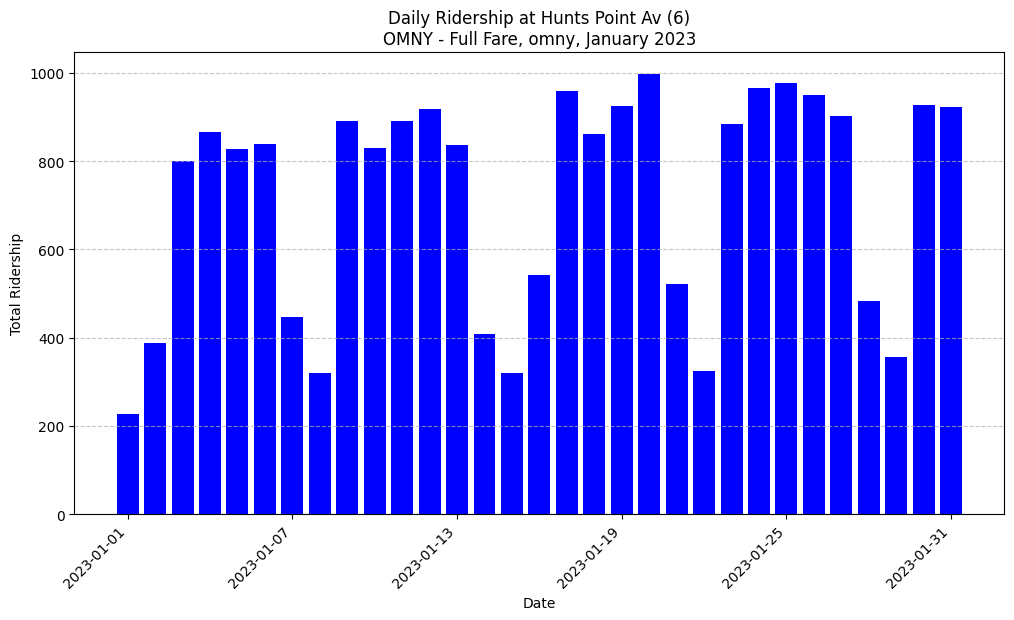

In [14]:
plot_station_ridership(df, 'OMNY - Full Fare', "omny", 2023, month = 1, station_identifier="371")

In [15]:
spark.stop()